# Airflow DAG Generation Model Evaluation

This notebook evaluates the quality of Airflow DAGs generated by:
- **Baseline**: Qwen 2.5 1.5B Instruct (standard model)
- **Fine-tuned**: Qwen 2.5 1.5B Airflow-Instruct (our fine-tuned model)

## Evaluation Methods

1. **Parser-based Evaluation**: Using custom DAG parser (ATS + syntax validation)
2. **LLM-based Evaluation**: Using Claude to assess DAG quality across 4 categories

In [ ]:
!pip install seaborn

In [39]:
import sys
from pathlib import Path
# Add project root to path to allow absolute imports from 'research'
root_path = Path.cwd().parents[2]
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))

from research.data.lib.config_loader import get_api_key
from research.lib.batch_processor import ClaudeBatchProcessor


## 1. Load Generated DAG Datasets

In [ ]:
# Define dataset paths
BASE_DIR = Path.cwd().parent
INFERENCE_DIR = BASE_DIR / "datasets" / "inference"

# Dataset files (updated with correct filenames)
BASELINE_FILE = INFERENCE_DIR / "base_model_outputs_20251217_151724.jsonl"
FINETUNED_FILE = INFERENCE_DIR / "finetuned_model_outputs_20251217_151724.jsonl"

print(f"Baseline model dataset: {BASELINE_FILE.name}")
print(f"Fine-tuned model dataset: {FINETUNED_FILE.name}")
print(f"\nFiles exist:")
print(f"  Baseline: {BASELINE_FILE.exists()}")
print(f"  Fine-tuned: {FINETUNED_FILE.exists()}")

In [54]:
def load_generated_dags(file_path: Path) -> List[Dict]:
    """Load generated DAGs from JSONL file."""
    dags = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            try:
                record = json.loads(line.strip())
                # Extract DAG content from assistant message
                if 'messages' in record:
                    content = next((m['content'] for m in record['messages'] if m['role'] == 'assistant'), '')
                    record['dag_content'] = content
                    record['line_number'] = line_num
                    dags.append(record)
            except json.JSONDecodeError:
                print(f"Warning: Skipping malformed JSON at line {line_num}")
                continue
    return dags

# Load datasets
baseline_dags = load_generated_dags(BASELINE_FILE)
finetuned_dags = load_generated_dags(FINETUNED_FILE)

print(f"Loaded {len(baseline_dags)} DAGs from baseline model")
print(f"Loaded {len(finetuned_dags)} DAGs from fine-tuned model")

Loaded 412 DAGs from baseline model
Loaded 412 DAGs from fine-tuned model


In [67]:
from datasets import load_dataset
dataset = load_dataset(
    "andrea-t94/airflow-dag-dataset",
    split="test",
    download_mode="reuse_cache_if_exists"  # Use cached version if available
)

dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/560k [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/574k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7414 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/412 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/412 [00:00<?, ? examples/s]

Dataset({
    features: ['messages', 'metadata', 'source'],
    num_rows: 412
})

In [65]:
baseline_dags[0].get('dag_content', '')

'from airflow import DAG\nfrom airflow.operators.python_operator import PythonOperator\nfrom airflow.providers.snowflake.hooks.snowflake import SnowflakeHook\n\n# Define the default arguments for the DAG\ndefault_args = {\n    \'owner\': \'airflow\',\n    \'start_date\': \'2023-04-01\',\n    \'retries\': 3,\n    \'retry_delay\': 5 * 60,  # 5 minutes\n}\n\n# Create the DAG\ndag = DAG(\n    \'snowflake_product_load_validation\',\n    default_args=default_args,\n    description=\'Load sample product data into Snowflake and validate the data load\',\n    schedule_interval=None,  # Set this to your desired schedule interval\n)\n\n# Function to load sample product data into Snowflake\ndef load_sample_products():\n    hook = SnowflakeHook(snowflake_conn_id=\'your_snowflake_connection\')\n    \n    # Sample product data\n    products = [\n        {\'product_id\': 1, \'name\': \'Product A\', \'price\': 19.99},\n        {\'product_id\': 2, \'name\': \'Product B\', \'price\': 29.99},\n        {\'

## 2. Parser-Based Evaluation

Using the custom DAG parser to validate:
- Python syntax correctness
- DAG structure validity
- Task ID uniqueness and format
- Circular dependency detection

In [56]:
def evaluate_with_parser(dags: List[Dict], model_name: str) -> pd.DataFrame:
    """Evaluate DAGs using the custom parser."""
    validator = DAGValidator()
    results = []
    
    for idx, dag_record in enumerate(dags):
        content = dag_record.get('dag_content', '')
        metadata = dag_record.get('metadata', {})
        
        # Validate DAG content
        validation_errors = validator.validate_content(content, f"dag_{idx}")
        
        # Categorize errors
        error_types = [error.error_type for error in validation_errors]
        
        result = {
            'model': model_name,
            'dag_id': idx,
            'line_number': dag_record.get('line_number', idx),
            'airflow_version': metadata.get('airflow_version', 'unknown'),
            'validation_passed': len(validation_errors) == 0,
            'num_errors': len(validation_errors),
            'has_syntax_error': 'SYNTAX_ERROR' in error_types,
            'has_parse_error': 'PARSE_ERROR' in error_types,
            'has_duplicate_task_id': 'DUPLICATE_TASK_ID' in error_types,
            'has_invalid_task_id': 'INVALID_TASK_ID' in error_types,
            'has_circular_dependency': 'CIRCULAR_DEPENDENCY' in error_types,
            'error_types': '; '.join(error_types) if error_types else '',
        }
        results.append(result)
    
    return pd.DataFrame(results)

# Evaluate both models
print("Evaluating baseline model...")
baseline_parser_results = evaluate_with_parser(baseline_dags, "Baseline (Qwen 2.5 1.5B Instruct)")

print("Evaluating fine-tuned model...")
finetuned_parser_results = evaluate_with_parser(finetuned_dags, "Fine-tuned (Qwen 2.5 1.5B Airflow)")

# Combine results
parser_results = pd.concat([baseline_parser_results, finetuned_parser_results], ignore_index=True)

print("\nParser evaluation completed!")

Evaluating baseline model...
Evaluating fine-tuned model...

Parser evaluation completed!


In [57]:
# Display parser evaluation summary
summary = parser_results.groupby('model').agg({
    'dag_id': 'count',
    'validation_passed': 'sum',
    'has_syntax_error': 'sum',
    'has_parse_error': 'sum',
    'has_duplicate_task_id': 'sum',
    'has_invalid_task_id': 'sum',
    'has_circular_dependency': 'sum',
}).rename(columns={
    'dag_id': 'Total DAGs',
    'validation_passed': 'Passed',
    'has_syntax_error': 'Syntax Errors',
    'has_parse_error': 'Parse Errors',
    'has_duplicate_task_id': 'Duplicate Task IDs',
    'has_invalid_task_id': 'Invalid Task IDs',
    'has_circular_dependency': 'Circular Dependencies',
})

# Add success rate
summary['Success Rate (%)'] = (summary['Passed'] / summary['Total DAGs'] * 100).round(2)

print("\n=== Parser-Based Evaluation Summary ===")
print(summary)


=== Parser-Based Evaluation Summary ===
                                    Total DAGs  Passed  Syntax Errors  \
model                                                                   
Baseline (Qwen 2.5 1.5B Instruct)          412     395             13   
Fine-tuned (Qwen 2.5 1.5B Airflow)         412     293            115   

                                    Parse Errors  Duplicate Task IDs  \
model                                                                  
Baseline (Qwen 2.5 1.5B Instruct)              0                   0   
Fine-tuned (Qwen 2.5 1.5B Airflow)             0                   2   

                                    Invalid Task IDs  Circular Dependencies  \
model                                                                         
Baseline (Qwen 2.5 1.5B Instruct)                  4                      0   
Fine-tuned (Qwen 2.5 1.5B Airflow)                 0                      3   

                                    Success Rate (%)  
model

## 3. Visualize Parser Results

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andreatamburri/Desktop/airflowNet/datasets/eval/parser_evaluation_comparison.png'

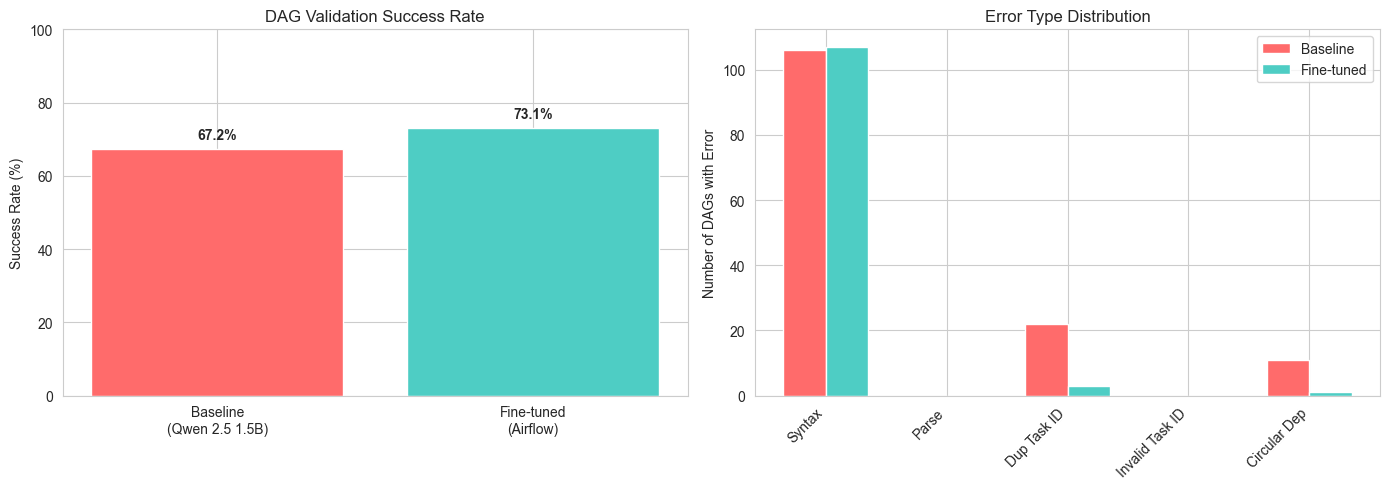

In [ ]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Success Rate
model_labels = ['Baseline\n(Qwen 2.5 1.5B)', 'Fine-tuned\n(Airflow)']
success_rates = [
    baseline_parser_results['validation_passed'].mean() * 100,
    finetuned_parser_results['validation_passed'].mean() * 100
]

axes[0].bar(model_labels, success_rates, color=['#FF6B6B', '#4ECDC4'])
axes[0].set_ylabel('Success Rate (%)')
axes[0].set_title('DAG Validation Success Rate')
axes[0].set_ylim(0, 100)
for i, v in enumerate(success_rates):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Error Type Distribution
error_cols = ['has_syntax_error', 'has_parse_error', 'has_duplicate_task_id', 
              'has_invalid_task_id', 'has_circular_dependency']
error_labels = ['Syntax', 'Parse', 'Dup Task ID', 'Invalid Task ID', 'Circular Dep']

baseline_errors = [baseline_parser_results[col].sum() for col in error_cols]
finetuned_errors = [finetuned_parser_results[col].sum() for col in error_cols]

x = range(len(error_labels))
width = 0.35

axes[1].bar([i - width/2 for i in x], baseline_errors, width, label='Baseline', color='#FF6B6B')
axes[1].bar([i + width/2 for i in x], finetuned_errors, width, label='Fine-tuned', color='#4ECDC4')
axes[1].set_ylabel('Number of DAGs with Error')
axes[1].set_title('Error Type Distribution')
axes[1].set_xticks(x)
axes[1].set_xticklabels(error_labels, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nVisualization saved to: datasets/eval/parser_evaluation_comparison.png")

## 4. LLM-Based Evaluation with Claude

Using Claude to evaluate DAG quality across 4 categories:
1. **Correctness**: Syntactic and semantic correctness
2. **Completeness**: All required components present
3. **Best Practices**: Following Airflow conventions
4. **Code Quality**: Readability and maintainability

In [ ]:
# LLM Evaluation Prompt (placeholder - user will provide better version)

LLM_EVAL_PROMPT_TEMPLATE = """
You are an expert Senior Apache Airflow Architect. Evaluate the following Airflow DAG code generated by an AI model based on a user instruction.

### Scoring Criteria & Examples

**1. Idiomatic Airflow (Score 0 or 1)**
* **Score 1 (Pass):** Uses specific Providers and Operators designed for the task.
    * *Example:* `from airflow.providers.snowflake.operators.snowflake import SnowflakeOperator`
* **Score 0 (Fail):** Relies on generic "Pythonic" patterns where it wraps logic in a `PythonOperator` + Hook instead of using the native Operator.
    * *Example:* `def load(): hook = SnowflakeHook(...) \n PythonOperator(python_callable=load ...)`

**2. No Hallucination/Leakage (Score 0 or 1)**
* **Score 1 (Pass):** Code is clean, production-ready, and uses only standard Airflow libraries.
* **Score 0 (Fail):** Code imports internal testing modules or includes test harness boilerplate.
    * *Example:* `from tests_common.test_utils.system_tests import get_test_run`
    * *Example:* `test_run = get_test_run(dag)`

**3. Instruction Adherence (Score 0 or 1)**
* **Score 1 (Pass):** Fulfills the specific business logic requested (e.g., "load data AND validate").
* **Score 0 (Fail):** Misses a key step of the instruction.

---

### Task
USER INSTRUCTION:
{instruction}

DAG CODE:
```python
{dag_content}
```


Evaluate the code based on the criteria above. Return valid JSON only.

{{{{
  "idiomatic_airflow": {{{{ "score": 0, "reasoning": "..." }}}}
  "no_hallucination": {{{{ "score": 0, "reasoning": "..." }}}},
  "instruction_adherence": {{{{ "score": 0, "reasoning": "..." }}}}
}}}}
"""

In [81]:
def prepare_llm_batch_requests(dags: List[Dict], parser_results_df: pd.DataFrame, 
                                model_name: str, 
                                prompt_template: str = LLM_EVAL_PROMPT_TEMPLATE) -> List[Dict]:
    """Prepare batch requests for Claude LLM evaluation.
    
    Includes all DAGs with DAG generation requests (even if they failed parser validation).
    """
    batch_requests = []
    
    print(f"Preparing requests for all {len(parser_results_df)} DAGs...")
    
    skipped_non_dag = 0
    
    for _, row in parser_results_df.iterrows():
        dag_id = row['dag_id']
        dag_record = dags[dag_id]
        
        content = dag_record.get('dag_content', '')
        messages = dag_record.get('messages', [])
        
        # Extract system message to check if it's a DAG generation request
        system_message = next((m['content'] for m in messages if m['role'] == 'system'), '')
        
        # Only include DAG generation requests (filter out other types)
        if not system_message.startswith("You are an expert Apache Airflow developer"):
            skipped_non_dag += 1
            continue
        
        # Extract user requirement from user message
        user_requirement = next((m['content'] for m in messages if m['role'] == 'user'), 'N/A')
        
        # Create prompt
        prompt = prompt_template.format(
            dag_content=content[:4000],  # Truncate if too long
            instruction=user_requirement
        )
        
        # Create batch request
        request = {
            "custom_id": f"{model_name}_dag_{dag_id}",
            "params": {
                "model": "claude-sonnet-4-5-20250929",  # Claude Sonnet 4.5
                "max_tokens": 2000,
                "temperature": 0.0,
                "messages": [{"role": "user", "content": prompt}]
            }
        }
        
        batch_requests.append(request)
    
    if skipped_non_dag > 0:
        print(f"Skipped {skipped_non_dag} non-DAG generation requests")
    
    return batch_requests

print("Preparing LLM evaluation batch requests (including DAGs that failed parser validation)...")

baseline_batch_requests = prepare_llm_batch_requests(
    baseline_dags, 
    baseline_parser_results,
    "baseline"
)
finetuned_batch_requests = prepare_llm_batch_requests(
    finetuned_dags, 
    finetuned_parser_results,
    "finetuned"
)

# Combine all requests
all_batch_requests = baseline_batch_requests + finetuned_batch_requests

print(f"\n📊 Summary:")
print(f"  Baseline: {len(baseline_batch_requests)} DAGs to evaluate")
print(f"  Fine-tuned: {len(finetuned_batch_requests)} DAGs to evaluate")
print(f"  Total requests: {len(all_batch_requests)}")
print(f"\n💰 Estimated cost with Sonnet 4.5: ~${len(all_batch_requests) * 0.02:.2f}")
print(f"   (Batch pricing: ~$1.50 per 1K input tokens, ~$7.50 per 1K output tokens)")
print(f"   Model: claude-sonnet-4-5-20250929 🚀 (Claude Sonnet 4.5)")

Preparing LLM evaluation batch requests (including DAGs that failed parser validation)...
Preparing requests for all 412 DAGs...
Skipped 70 non-DAG generation requests
Preparing requests for all 412 DAGs...
Skipped 70 non-DAG generation requests

📊 Summary:
  Baseline: 342 DAGs to evaluate
  Fine-tuned: 342 DAGs to evaluate
  Total requests: 684

💰 Estimated cost with Sonnet 4.5: ~$13.68
   (Batch pricing: ~$1.50 per 1K input tokens, ~$7.50 per 1K output tokens)
   Model: claude-sonnet-4-5-20250929 🚀 (Claude Sonnet 4.5)


In [82]:
def submit_claude_batch(requests: List[Dict]) -> str:
    """Submit batch requests using ClaudeBatchProcessor."""
    api_key = get_api_key()
    processor = ClaudeBatchProcessor(api_key=api_key)
    return processor.submit_batch(requests)

# Submit batch (uncomment to run)
# batch_id = submit_claude_batch(all_batch_requests)
# print(f"Batch ID: {batch_id}")


Submitting batch with 684 requests to Claude...
✅ Batch submitted successfully!
Batch ID: msgbatch_01DQRjbUW3fndR7oQgMySgHY
Status: in_progress

⚠️  To submit the batch for LLM evaluation, uncomment and run the above cell.
Make sure ANTHROPIC_API_KEY is set in your .env file or environment.


In [91]:
def wait_for_batch_completion(batch_id: str, poll_interval: int = 60) -> object:
    """Wait for batch using ClaudeBatchProcessor."""
    api_key = get_api_key()
    processor = ClaudeBatchProcessor(api_key=api_key, poll_interval=poll_interval)
    return processor.wait_for_batch_completion(batch_id)

# Wait for batch
# batch_result = wait_for_batch_completion(batch_id)


Waiting for batch msgbatch_01DQRjbUW3fndR7oQgMySgHY to complete...
Polling every 60 seconds...

[0s] Status: ended | Processed: 684/684

✅ Batch completed in 0s!

⚠️  After submitting a batch, use this cell to wait for completion.


In [90]:
# Check detailed batch status
api_key = get_api_key()
client = anthropic.Anthropic(api_key=api_key)

batch = client.beta.messages.batches.retrieve("msgbatch_01DQRjbUW3fndR7oQgMySgHY")
print(f"Batch ID: {batch.id}")
print(f"Processing status: {batch.processing_status}")
print(f"Created at: {batch.created_at}")
print(f"Expires at: {batch.expires_at}")
print(f"\nRequest counts:")
if hasattr(batch, 'request_counts'):
    print(f"  Processing: {batch.request_counts.processing}")
    print(f"  Succeeded: {batch.request_counts.succeeded}")
    print(f"  Errored: {batch.request_counts.errored}")
    print(f"  Canceled: {batch.request_counts.canceled}")
    print(f"  Expired: {batch.request_counts.expired}")

Batch ID: msgbatch_01DQRjbUW3fndR7oQgMySgHY
Processing status: ended
Created at: 2025-12-18 15:10:05.939682+00:00
Expires at: 2025-12-19 15:10:05.939682+00:00

Request counts:
  Processing: 0
  Succeeded: 684
  Errored: 0
  Canceled: 0
  Expired: 0


In [97]:
def retrieve_and_parse_batch_results(batch_id: str, show_failures: bool = False) -> pd.DataFrame:
    """Retrieve and parse results using ClaudeBatchProcessor."""
    api_key = get_api_key()
    processor = ClaudeBatchProcessor(api_key=api_key)
    
    print(f"Retrieving results for batch {batch_id}...")
    # Download results (returns list of normalized dicts)
    raw_results = processor.download_batch_results(batch_id)
    
    results = []
    failures = []
    
    for item in raw_results:
        # Check if succeeded using normalized structure
        if item.get('result', {}).get('type') == 'succeeded':
            custom_id = item['custom_id']
            try:
                # Access content safely
                content = item['result']['message']['content'][0]['text']
            except (KeyError, IndexError):
                content = ""
            
            # Parse custom_id (same logic as before)
            parts = custom_id.split('_')
            if parts[0] == 'ground' and len(parts) == 4:
                model_type = 'ground_truth'
                dag_id = int(parts[3])
            else:
                model_type = parts[0]
                dag_id = int(parts[2])
            
            try:
                import re
                import json
                json_match = re.search(r'\{.*\}', content, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                    eval_data = json.loads(json_str)
                else:
                    raise ValueError("No JSON object found")
                
                if model_type == 'baseline':
                    model_name = 'Baseline (Qwen 2.5 1.5B Instruct)'
                elif model_type == 'finetuned':
                    model_name = 'Fine-tuned (Qwen 2.5 1.5B Airflow)'
                elif model_type == 'ground_truth':
                    model_name = 'Ground Truth (HuggingFace)'
                else:
                    model_name = model_type
                
                result_row = {
                    'model': model_name,
                    'dag_id': dag_id,
                    'idiomatic_airflow_score': eval_data.get('idiomatic_airflow', {}).get('score', 0),
                    'idiomatic_airflow_reasoning': eval_data.get('idiomatic_airflow', {}).get('reasoning', ''),
                    'no_hallucination_score': eval_data.get('no_hallucination', {}).get('score', 0),
                    'no_hallucination_reasoning': eval_data.get('no_hallucination', {}).get('reasoning', ''),
                    'instruction_adherence_score': eval_data.get('instruction_adherence', {}).get('score', 0),
                    'instruction_adherence_reasoning': eval_data.get('instruction_adherence', {}).get('reasoning', ''),
                }
                
                result_row['overall_score'] = (
                    result_row['idiomatic_airflow_score'] + 
                    result_row['no_hallucination_score'] + 
                    result_row['instruction_adherence_score']
                ) / 3.0
                
                results.append(result_row)
            
            except Exception as e:
                failures.append({'custom_id': custom_id, 'error': str(e), 'content_preview': content[:200]})
                continue
    
    df = pd.DataFrame(results)
    print(f"\n✅ Successfully parsed: {len(df)} results")
    print(f"❌ Failed to parse: {len(failures)} results")
    return df



⚠️  Set show_failures=False to hide parsing error details.


In [ ]:
llm_results = retrieve_and_parse_batch_results(batch_id, show_failures=True)

print("\n⚠️  Results from baseline/finetuned batch evaluation.")

## 6. Ground Truth Evaluation Against Original HuggingFace Dataset

Compare generated outputs with the ground truth from the original test dataset.

In [73]:
# Load original HuggingFace test dataset for ground truth comparison
from datasets import load_dataset

print("Loading original HuggingFace test dataset...")
hf_test_dataset = load_dataset(
    "andrea-t94/airflow-dag-dataset",
    split="test",
    download_mode="reuse_cache_if_exists"
)

print(f"✅ Loaded {len(hf_test_dataset)} ground truth examples")

# Extract ground truth DAG contents in the format expected by evaluate_with_parser
# The evaluate_with_parser function expects: List[Dict] where each dict has 'dag_content' key
ground_truth_dags = []
for example in hf_test_dataset:
    messages = example['messages']
    # Find the assistant message (ground truth)
    gt_content = next((m['content'] for m in messages if m['role'] == 'assistant'), '')
    
    # Format for evaluate_with_parser function
    ground_truth_dags.append({
        'dag_content': gt_content,  # Required key
        'metadata': example.get('metadata', {}) or {},
        'source': example.get('source', 'unknown')
    })

print(f"\nDataset composition:")
airflow_count = sum(1 for x in hf_test_dataset if x.get('source') == 'airflow')
magpie_count = sum(1 for x in hf_test_dataset if x.get('source') == 'magpie')
print(f"  - Airflow examples: {airflow_count} ({airflow_count/len(hf_test_dataset)*100:.1f}%)")
print(f"  - Magpie examples: {magpie_count} ({magpie_count/len(hf_test_dataset)*100:.1f}%)")

print(f"\n✅ Formatted {len(ground_truth_dags)} DAGs for parser evaluation")
print(f"   Example keys: {list(ground_truth_dags[0].keys())}")

Loading original HuggingFace test dataset...


Generating train split:   0%|          | 0/7414 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/412 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/412 [00:00<?, ? examples/s]

✅ Loaded 412 ground truth examples

Dataset composition:
  - Airflow examples: 342 (83.0%)
  - Magpie examples: 70 (17.0%)

✅ Formatted 412 DAGs for parser evaluation
   Example keys: ['dag_content', 'metadata', 'source']


In [74]:
ground_truth_dags[0]['metadata']

{'file_name': 'dag_1798_variant_1',
 'instruction_source': 'claude-3.5',
 'variant_number': 1,
 'airflow_version': '3.0.1'}

In [75]:
# Evaluate ground truth DAGs with parser
print("Evaluating ground truth DAGs with parser...")
ground_truth_parser_results = evaluate_with_parser(ground_truth_dags, "Ground Truth (HuggingFace)")

print("\n=== Ground Truth Parser Evaluation Summary ===")
gt_summary = ground_truth_parser_results.agg({
    'dag_id': 'count',
    'validation_passed': 'sum',
    'has_syntax_error': 'sum',
    'has_parse_error': 'sum',
    'has_duplicate_task_id': 'sum',
    'has_invalid_task_id': 'sum',
    'has_circular_dependency': 'sum',
})

print(f"Total DAGs: {gt_summary['dag_id']}")
print(f"Passed: {gt_summary['validation_passed']}")
print(f"Success Rate: {gt_summary['validation_passed']/gt_summary['dag_id']*100:.2f}%")
print(f"Syntax Errors: {gt_summary['has_syntax_error']}")
print(f"Duplicate Task IDs: {gt_summary['has_duplicate_task_id']}")
print(f"Circular Dependencies: {gt_summary['has_circular_dependency']}")

Evaluating ground truth DAGs with parser...

=== Ground Truth Parser Evaluation Summary ===
Total DAGs: 412
Passed: 328
Success Rate: 79.61%
Syntax Errors: 70
Duplicate Task IDs: 3
Circular Dependencies: 1


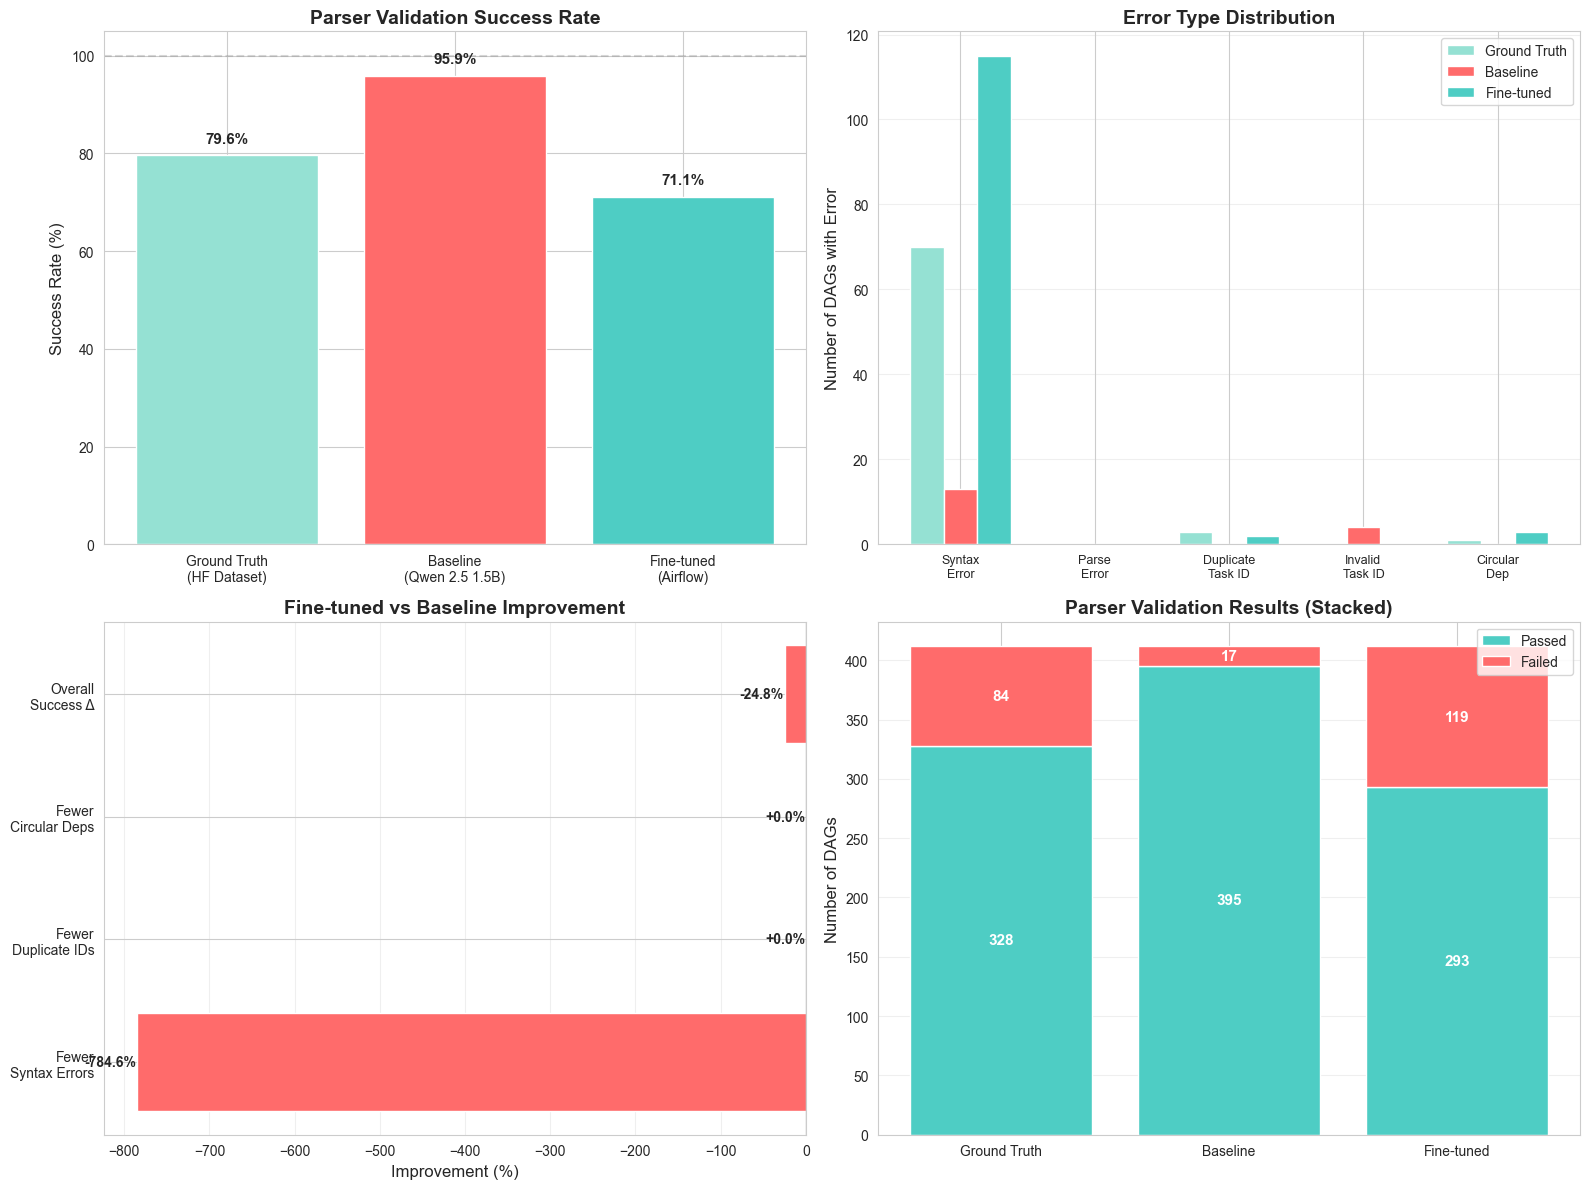

In [86]:
# Compare all three: Ground Truth, Baseline, and Fine-tuned
combined_parser_results = pd.concat([
    ground_truth_parser_results, 
    baseline_parser_results, 
    finetuned_parser_results
], ignore_index=True)

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Success Rate Comparison (including Ground Truth)
model_labels = ['Ground Truth\n(HF Dataset)', 'Baseline\n(Qwen 2.5 1.5B)', 'Fine-tuned\n(Airflow)']
success_rates = [
    ground_truth_parser_results['validation_passed'].mean() * 100,
    baseline_parser_results['validation_passed'].mean() * 100,
    finetuned_parser_results['validation_passed'].mean() * 100
]
colors = ['#95E1D3', '#FF6B6B', '#4ECDC4']

axes[0, 0].bar(model_labels, success_rates, color=colors)
axes[0, 0].set_ylabel('Success Rate (%)', fontsize=12)
axes[0, 0].set_title('Parser Validation Success Rate', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 105)
axes[0, 0].axhline(y=100, color='gray', linestyle='--', alpha=0.3)

for i, v in enumerate(success_rates):
    axes[0, 0].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Error Type Distribution
error_cols = ['has_syntax_error', 'has_parse_error', 'has_duplicate_task_id', 
              'has_invalid_task_id', 'has_circular_dependency']
error_labels = ['Syntax\nError', 'Parse\nError', 'Duplicate\nTask ID', 'Invalid\nTask ID', 'Circular\nDep']

gt_errors = [ground_truth_parser_results[col].sum() for col in error_cols]
baseline_errors = [baseline_parser_results[col].sum() for col in error_cols]
finetuned_errors = [finetuned_parser_results[col].sum() for col in error_cols]

x = range(len(error_labels))
width = 0.25

axes[0, 1].bar([i - width for i in x], gt_errors, width, label='Ground Truth', color='#95E1D3')
axes[0, 1].bar([i for i in x], baseline_errors, width, label='Baseline', color='#FF6B6B')
axes[0, 1].bar([i + width for i in x], finetuned_errors, width, label='Fine-tuned', color='#4ECDC4')
axes[0, 1].set_ylabel('Number of DAGs with Error', fontsize=12)
axes[0, 1].set_title('Error Type Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(error_labels, fontsize=9)
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Improvement Over Baseline
improvements = {
    'Fewer\nSyntax Errors': (baseline_errors[0] - finetuned_errors[0]) / max(baseline_errors[0], 1) * 100,
    'Fewer\nDuplicate IDs': (baseline_errors[2] - finetuned_errors[2]) / max(baseline_errors[2], 1) * 100 if baseline_errors[2] > 0 else 0,
    'Fewer\nCircular Deps': (baseline_errors[4] - finetuned_errors[4]) / max(baseline_errors[4], 1) * 100 if baseline_errors[4] > 0 else 0,
    'Overall\nSuccess Δ': success_rates[2] - success_rates[1]
}

improvement_colors = ['#4ECDC4' if v > 0 else '#FF6B6B' for v in improvements.values()]
axes[1, 0].barh(list(improvements.keys()), list(improvements.values()), color=improvement_colors)
axes[1, 0].set_xlabel('Improvement (%)', fontsize=12)
axes[1, 0].set_title('Fine-tuned vs Baseline Improvement', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].grid(axis='x', alpha=0.3)

for i, v in enumerate(improvements.values()):
    axes[1, 0].text(v + 1 if v > 0 else v - 1, i, f'{v:+.1f}%', 
                    va='center', ha='left' if v > 0 else 'right', fontweight='bold', fontsize=10)

# Plot 4: Success vs Error Breakdown (Stacked)
models = ['Ground Truth', 'Baseline', 'Fine-tuned']
passed = [
    ground_truth_parser_results['validation_passed'].sum(),
    baseline_parser_results['validation_passed'].sum(),
    finetuned_parser_results['validation_passed'].sum()
]
failed = [
    len(ground_truth_parser_results) - passed[0],
    len(baseline_parser_results) - passed[1],
    len(finetuned_parser_results) - passed[2]
]

axes[1, 1].bar(models, passed, label='Passed', color='#4ECDC4')
axes[1, 1].bar(models, failed, bottom=passed, label='Failed', color='#FF6B6B')
axes[1, 1].set_ylabel('Number of DAGs', fontsize=12)
axes[1, 1].set_title('Parser Validation Results (Stacked)', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (p, f) in enumerate(zip(passed, failed)):
    if p > 0:
        axes[1, 1].text(i, p/2, f'{p}', ha='center', va='center', fontweight='bold', fontsize=11, color='white')
    if f > 0:
        axes[1, 1].text(i, p + f/2, f'{f}', ha='center', va='center', fontweight='bold', fontsize=11, color='white')

plt.tight_layout()
plt.show()

In [89]:
def prepare_ground_truth_llm_batch_requests(ground_truth_data: List[Dict], 
                                             hf_dataset,
                                             parser_results_df: pd.DataFrame,
                                             model_name: str = "ground_truth",
                                             prompt_template: str = LLM_EVAL_PROMPT_TEMPLATE) -> List[Dict]:
    """Prepare batch requests for ground truth LLM evaluation.
    
    Ground truth has a different structure - uses HuggingFace dataset with messages field.
    Only evaluates DAGs from 'airflow' source.
    """
    batch_requests = []
    
    print(f"Preparing requests for ground truth DAGs...")
    
    skipped_magpie = 0
    
    for idx, (dag_record, hf_example) in enumerate(zip(ground_truth_data, hf_dataset)):
        # Filter: only include 'airflow' source examples
        source = dag_record.get('source', '')
        if source != 'airflow':
            skipped_magpie += 1
            continue
        
        content = dag_record.get('dag_content', '')
        
        # Extract user instruction from HuggingFace dataset messages
        messages = hf_example.get('messages', [])
        user_instruction = next((m['content'] for m in messages if m['role'] == 'user'), 'N/A')
        
        # Create prompt
        prompt = prompt_template.format(
            dag_content=content[:4000],  # Truncate if too long
            instruction=user_instruction
        )
        
        # Create batch request
        request = {
            "custom_id": f"{model_name}_dag_{idx}",
            "params": {
                "model": "claude-sonnet-4-5-20250929",  # Claude Sonnet 4.5
                "max_tokens": 2000,
                "temperature": 0.0,
                "messages": [{"role": "user", "content": prompt}]
            }
        }
        
        batch_requests.append(request)
    
    print(f"  Created {len(batch_requests)} requests from 'airflow' source")
    print(f"  Skipped {skipped_magpie} 'magpie' source examples")
    
    return batch_requests

# Prepare ground truth batch requests
ground_batch_requests = prepare_ground_truth_llm_batch_requests(
    ground_truth_dags,
    hf_test_dataset,
    ground_truth_parser_results,
    "ground_truth"
)

print(f"\n📊 Ground Truth Summary:")
print(f"  Total requests: {len(ground_batch_requests)}")
print(f"\n💰 Estimated cost: ~${len(ground_batch_requests) * 0.02:.2f}")
print(f"   Model: claude-sonnet-4-5-20250929 🚀 (Claude Sonnet 4.5)")

Preparing requests for ground truth DAGs...
  Created 342 requests from 'airflow' source
  Skipped 70 'magpie' source examples

📊 Ground Truth Summary:
  Total requests: 342

💰 Estimated cost: ~$6.84
   Model: claude-sonnet-4-5-20250929 🚀 (Claude Sonnet 4.5)


In [93]:
batch_id = submit_claude_batch(ground_batch_requests)

Submitting batch with 342 requests to Claude...
✅ Batch submitted successfully!
Batch ID: msgbatch_01Kpbjj1oLW6rUay1bfZdVYq
Status: in_progress


In [98]:
batch_result = wait_for_batch_completion(batch_id)
gt_llm_results = retrieve_and_parse_batch_results(batch_id, show_failures=True)

Waiting for batch msgbatch_01Kpbjj1oLW6rUay1bfZdVYq to complete...
Polling every 60 seconds...

[0s] Status: ended | Processed: 342/342

✅ Batch completed in 0s!
Retrieving results for batch msgbatch_01Kpbjj1oLW6rUay1bfZdVYq...

✅ Successfully parsed: 342 results
❌ Failed to parse: 0 results


In [100]:
# Combine all LLM evaluation results
all_llm_results = pd.concat([gt_llm_results, llm_results], ignore_index=True)

# Calculate summary statistics by model
llm_summary = all_llm_results.groupby('model').agg({
    'dag_id': 'count',
    'idiomatic_airflow_score': 'mean',
    'no_hallucination_score': 'mean',
    'instruction_adherence_score': 'mean',
    'overall_score': 'mean'
}).rename(columns={
    'dag_id': 'Total Evaluated',
    'idiomatic_airflow_score': 'Idiomatic Airflow (avg)',
    'no_hallucination_score': 'No Hallucination (avg)',
    'instruction_adherence_score': 'Instruction Adherence (avg)',
    'overall_score': 'Overall Score (avg)'
})

# Round to 3 decimal places for readability
llm_summary = llm_summary.round(3)

print("\n" + "="*80)
print("LLM EVALUATION SUMMARY (Claude Sonnet 4.5)")
print("="*80)
print(llm_summary)
print("\n" + "="*80)

# Calculate pass rates (score = 1) for each criterion
pass_rates = all_llm_results.groupby('model').agg({
    'idiomatic_airflow_score': lambda x: (x == 1).sum() / len(x) * 100,
    'no_hallucination_score': lambda x: (x == 1).sum() / len(x) * 100,
    'instruction_adherence_score': lambda x: (x == 1).sum() / len(x) * 100,
}).rename(columns={
    'idiomatic_airflow_score': 'Idiomatic Airflow Pass %',
    'no_hallucination_score': 'No Hallucination Pass %',
    'instruction_adherence_score': 'Instruction Adherence Pass %'
}).round(2)

print("\nPASS RATES (% of DAGs with score = 1)")
print("="*80)
print(pass_rates)
print("="*80)


LLM EVALUATION SUMMARY (Claude Sonnet 4.5)
                                    Total Evaluated  Idiomatic Airflow (avg)  \
model                                                                          
Baseline (Qwen 2.5 1.5B Instruct)               342                    0.108   
Fine-tuned (Qwen 2.5 1.5B Airflow)              341                    0.428   
Ground Truth (HuggingFace)                      342                    0.906   

                                    No Hallucination (avg)  \
model                                                        
Baseline (Qwen 2.5 1.5B Instruct)                    0.246   
Fine-tuned (Qwen 2.5 1.5B Airflow)                   0.062   
Ground Truth (HuggingFace)                           0.173   

                                    Instruction Adherence (avg)  \
model                                                             
Baseline (Qwen 2.5 1.5B Instruct)                         0.155   
Fine-tuned (Qwen 2.5 1.5B Airflow)         

In [108]:
all_llm_results.to_csv('llm_evals.csv')

## 7. LLM Evaluation Results Summary

Compare LLM evaluation scores across all three models: Ground Truth, Baseline, and Fine-tuned.